In [1]:
from joblib import load
from typing import Any, Dict, Sequence

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import seaborn.objects as so
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.inspection import PartialDependenceDisplay
from sklearn import metrics
import dtreeviz
import scikitplot
import xgboost as xgb
import xgbfir
import yellowbrick.model_selection as ms
from yellowbrick import classifier
import shap
shap.initjs()

pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
color_palette = ["#1E1A0F", "#3F3128", "#644B35", "#A76F53", "#DCA98E", "#D7C9AC", "#689399", "#575735", "#343D22", "#152411"]

# Define the custom colormap
cmap_name = 'custom_palette'
cm = plt.cm.colors.LinearSegmentedColormap.from_list(cmap_name, color_palette, N=len(color_palette))
sns.set_palette(color_palette)
sns.set_style("white", {"grid.color": "#ffffff", "axes.facecolor": "w", 'figure.facecolor':'white'})

In [3]:
# Load the model
loaded_model = load('streamlit_gallery/utils/best_model_bank_marketing.joblib')
    
# Load the pipeline
loaded_pipeline = load('streamlit_gallery/utils/best_pipeline_bank_marketing.joblib')

# Load the trials object
loaded_trials = pd.read_csv('streamlit_gallery/utils/hyperopt_trials.csv')

optimal_threshold = 0.27272727272727276

In [4]:
df = (pd
      .read_csv("bank-full.csv", sep=';')
      .rename(columns={'y': 'deposit'})
     )
df.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome deposit  
0  unknown    5   may       261         1     -1         0  unknown      no  
1  unknown    5   may       151         1     -1         0  unknown      no  
2  unknown    5   may        76         1     -1         0  unknown      no  
3  unknown    5   may        92         1     -1         0  unknown      no  
4  unknown    5   may       198         1     -1         0  unknown      no

In [5]:
label_encoder = LabelEncoder()
df = (df
      .assign(deposit=lambda df_: label_encoder.fit_transform(df_.deposit))
      .astype({'deposit': 'int8'})
     )
df

age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day month  duration  campaign  pdays  previous poutcome  \
0        unknown    5   may       261         1     -1         0  unknown   
1        unknown    5   may       151         1     -1         0  unknown   
2        unknown    5   may        76         1     -1         0  unknown   
3        unknown    5   may        92         1     -1         0  unknown   
4        unknown    5   may       198         1     -1         0  unknown   
...          ...  ...   ...       ...       ...    ...       ...      ...   
45206   cellular   17   nov       977         3     -1         0  unknown   
45207   cellular   17   nov       456         2     -1         0  unknown   
45208   cellular   17   nov      1127         5    184         3  success   
45209  telephone   17   nov       508         4     -1         0  unknown   
45210   cellular   17   nov       361         2    188        11    other   

       deposit  
0            0  
1            0  
2            0  
3            0  
4            0  
...        ...  
45206        1  
45207        1  
45208        1  
45209        0  
45210        0  

[45211 rows x 17 columns]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['deposit']),
                                                    df[['deposit']].values.ravel(),
                                                    test_size=0.2,
                                                    stratify=df[['deposit']].values.ravel(),
                                                    random_state=42)

### Dummy Instances

In [7]:
no_client = {'age': 58,
             'job': 'management',
             'marital': 'married',
             'education': 'tertiary',
             'default': 'no',
             'balance': 2143,
             'housing': 'yes',
             'loan': 'no',
             'contact': 'unknown',
             'day': 5,
             'month': 'may',
             'duration': 261,
             'campaign': 1,
             'pdays': -1,
             'previous': 0,
             'poutcome': 'unknown'}
no_client = pd.DataFrame(no_client, index=range(1))
no_client

age         job  marital education default  balance housing loan  contact  \
0   58  management  married  tertiary      no     2143     yes   no  unknown   

   day month  duration  campaign  pdays  previous poutcome  
0    5   may       261         1     -1         0  unknown

In [8]:
yes_client = {'age': 58,
             'job': 'management',
             'marital': 'married',
             'education': 'tertiary',
             'default': 'no',
             'balance': 8000,
             'housing': 'no',
             'loan': 'no',
             'contact': 'cellular',
             'day': 15,
             'month': 'may',
             'duration': 500,
             'campaign': 2,
             'pdays': 3,
             'previous': 1,
             'poutcome': 'success'}
yes_client = pd.DataFrame(yes_client, index=range(1))
yes_client

age         job  marital education default  balance housing loan   contact  \
0   58  management  married  tertiary      no     8000      no   no  cellular   

   day month  duration  campaign  pdays  previous poutcome  
0   15   may       500         2      3         1  success

In [9]:
no_client_transformed = loaded_pipeline.transform(no_client)
yes_client_transformed = loaded_pipeline.transform(yes_client)

In [10]:
no_client_probability = loaded_model.predict_proba(no_client_transformed)[:,1]
no_client_prediction = (no_client_probability >= optimal_threshold).astype(int)

yes_client_probability = loaded_model.predict_proba(yes_client_transformed)[:,1]
yes_client_prediction = (yes_client_probability >= optimal_threshold).astype(int)

In [11]:
print(no_client_prediction, yes_client_prediction)

[0] [1]


In [12]:
loaded_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9342075051995091, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.00011012594406067856, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.12283892561637563, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=3.19227344664939, max_depth=8, max_leaves=None,
              min_child_weight=0.3358746339088806, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [13]:
loaded_pipeline

Pipeline(steps=[('tweak_bank_marketing', TweakBankMarketing()),
                ('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('standard_numerical_features',
                                                  Pipeline(steps=[('remove_outlier',
                                                                   OutlierTrans(outlierlist=['age',
                                                                                             'campaign',
                                                                                             'pdays',
                                                                                             'previous'])),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous']),
                                                 ('minmax_nu...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('orde',
                                                                   OrdinalEncoder(dtype='float'))]),
                                                  ['education', 'day',
                                                   'month'])],
                                   verbose=0,
                                   verbose_feature_names_out=False)),
                ('imputer', KNNImputer()),
                ('rfecv',
                 RFECV(cv=5,
                       estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=5, n_jobs=-1,
                                                        random_state=42),
                       min_features_to_select=5, n_jobs=-1,
                       scoring='roc_auc'))])

In [14]:
loaded_trials

colsample_bytree         gamma  learning_rate  max_delta_step  \
0             0.798910      0.026451       0.327522        4.898907   
1             0.785034  15279.511272       0.337039        3.691281   
2             0.811447     82.756091       0.214349        8.805868   
3             0.927012      0.000052       0.165280        9.579726   
4             0.771450      0.006431       0.125281        9.675096   
...                ...           ...            ...             ...   
1995          0.963556      0.000079       0.222276        2.426198   
1996          0.957718      0.000095       0.264869        2.493174   
1997          0.901269      0.000048       0.103768        3.962419   
1998          0.921164      0.000047       0.109447        3.900319   
1999          0.942609      0.000047       0.164842        3.221651   

      max_depth  min_child_weight  reg_alpha  reg_lambda  scale_pos_weight  \
0           4.0          0.450201   7.782111    3.333830          3.995456   
1           3.0          0.981026   1.125833    1.482015          2.856371   
2           6.0          3.801328   8.517860    9.444882          3.355658   
3           5.0          5.740173   6.061954    2.371698          3.362746   
4           3.0          5.871425   3.051340    9.433255          7.383438   
...         ...               ...        ...         ...               ...   
1995        5.0          0.448985   3.655024    8.341040          1.663645   
1996        5.0          0.492506   2.857648    8.275077          1.738945   
1997        6.0          0.363299   4.343016    8.905257          1.486700   
1998        6.0          0.352305   4.560448    9.139320          1.312101   
1999        6.0          0.376967   4.063658    8.533346          1.893347   

      subsample      loss   tid  
0      0.978178 -0.874378     0  
1      0.963567 -0.883003     1  
2      0.934727 -0.882893     2  
3      0.769372 -0.879465     3  
4      0.901740 -0.803937     4  
...         ...       ...   ...  
1995   0.924040 -0.894062  1995  
1996   0.935469 -0.893619  1996  
1997   0.944712 -0.894504  1997  
1998   0.953538 -0.896495  1998  
1999   0.948673 -0.891518  1999  

[2000 rows x 12 columns]

### Get feature names

In [15]:
(loaded_pipeline
 .named_steps['tweak_bank_marketing']
 .transform(no_client)
 .columns
)

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'campaign', 'pdays', 'previous',
       'poutcome', 'balance_pos', 'pdays_contacted', 'previous_contacted'],
      dtype='object')

In [16]:
input_features = (loaded_pipeline
                   .named_steps['tweak_bank_marketing']
                   .transform(no_client)
                   .columns
                 )

feature_names = (loaded_pipeline
                 .named_steps['col_trans']
                 .get_feature_names_out(input_features=input_features))

In [17]:
support_mask = loaded_pipeline.named_steps['rfecv'].get_support()
selected_features = np.array(feature_names)[support_mask]

In [18]:
selected_features

array(['age', 'campaign', 'pdays', 'previous', 'balance',
       'job_blue-collar', 'job_unemployed', 'marital_married',
       'marital_single', 'contact_unknown', 'poutcome_success',
       'poutcome_unknown', 'day', 'month', 'housing', 'loan',
       'pdays_contacted', 'previous_contacted'], dtype=object)

### Trials Object

In [19]:
def trial2df(trial: Sequence[Dict[str, Any]]) -> pd.DataFrame:
    vals = []
    for t in trial:
        result = t['result']
        misc = t['misc']
        val = {k:(v[0] if isinstance(v, list) else v)
               for k,v in misc['vals'].items()
              }
        val['loss'] = result['loss']
        val['tid'] = t['tid']
        vals.append(val)
    return pd.DataFrame(vals)

# hyper2hr = trial2df(loaded_trials)

In [20]:
# hyper2hr.to_csv('hyperopt_trials.csv', index=False)

In [21]:
hyper2hr = loaded_trials

In [22]:
(hyper2hr
 .corr(method='spearman')
 .style
 .background_gradient(cmap=cm, vmin=-1, vmax=1)
 .set_sticky(axis=0)
)

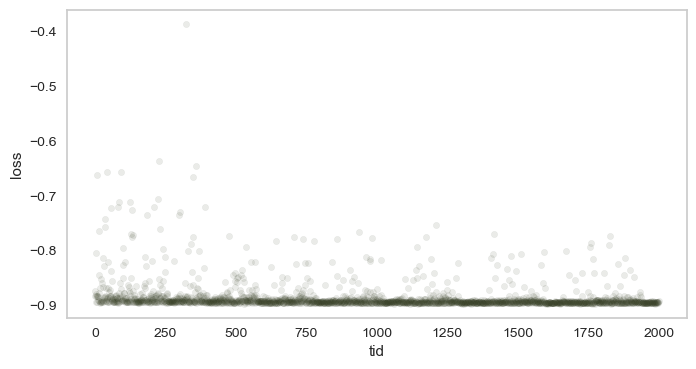

In [23]:
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
 .plot
 .scatter(x='tid', y='loss', alpha=.1, color=color_palette[8], ax=ax)
);

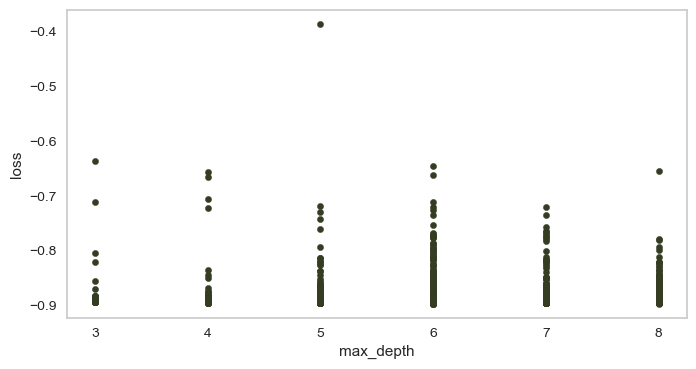

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))
(hyper2hr
 .plot
 .scatter(x='max_depth', y='loss', alpha=1, color=color_palette[8], ax=ax)
);

In [25]:
def jitter(df: pd.DataFrame, col: str, amount: float=1) -> pd.Series:
    """
    Add random noise to the values in a Pandas DataFraem column.
    
    This fn adds random noise to the values in a specified column of
    a Pandas DataFrame. The noise is uniform random noise with a range of amount
    centered around zero. The fn returns a Pandas Series with the jittered values.
    """
    vals = np.random.uniform(low=-amount/2, high=amount/2, size=df.shape[0])
    return df[col] + vals

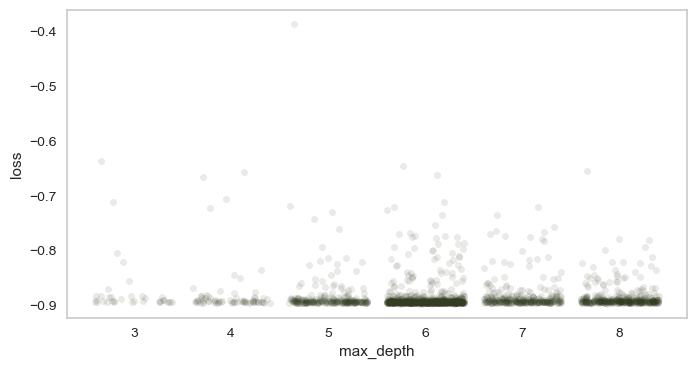

In [26]:
fig, ax = plt.subplots(figsize=(8,4))
(hyper2hr
 .assign(max_depth = lambda df: jitter(df, 'max_depth', amount=.8))
 .plot
 .scatter(x='max_depth', y='loss', alpha=.1, color=color_palette[8], ax=ax)
);

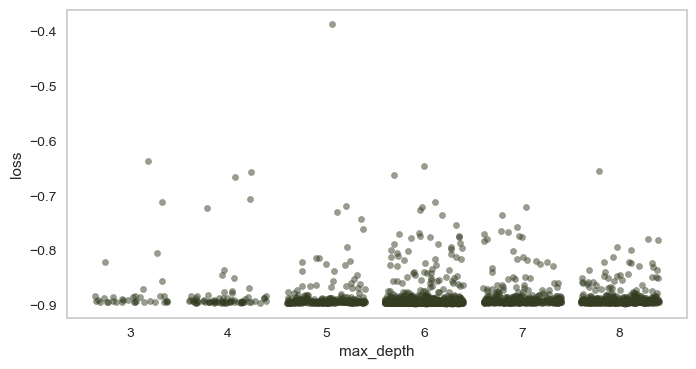

In [27]:
fig, ax = plt.subplots(figsize=(8, 4))

(hyper2hr
 .assign(max_depth=lambda df:jitter(df, 'max_depth', amount=.8))
 .plot
 .scatter(x='max_depth', y='loss', alpha=.5, color=color_palette[8], ax=ax)
);

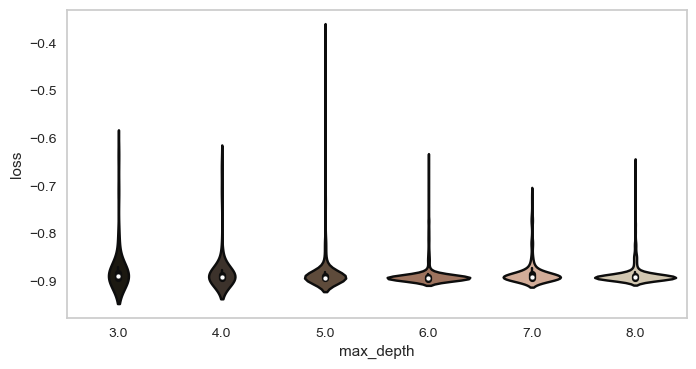

In [28]:
fig, ax = plt.subplots(figsize=(8,4))
sns.violinplot(x='max_depth', y='loss', data=hyper2hr, kind='violin', ax=ax);

'color' and 'colormap' cannot be used simultaneously. Using 'color'
No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


<Axes: xlabel='reg_alpha', ylabel='colsample_bytree'>

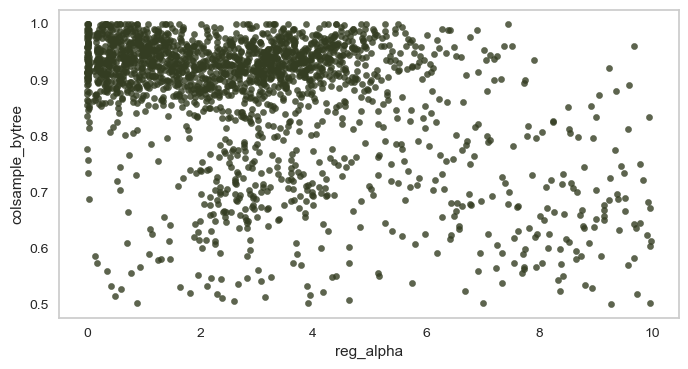

In [29]:
fig, ax = plt.subplots(figsize=(8,4))
(hyper2hr
 .plot
 .scatter(x='reg_alpha', y='colsample_bytree', alpha=.8, color=color_palette[8], cmap='viridis', ax=ax))

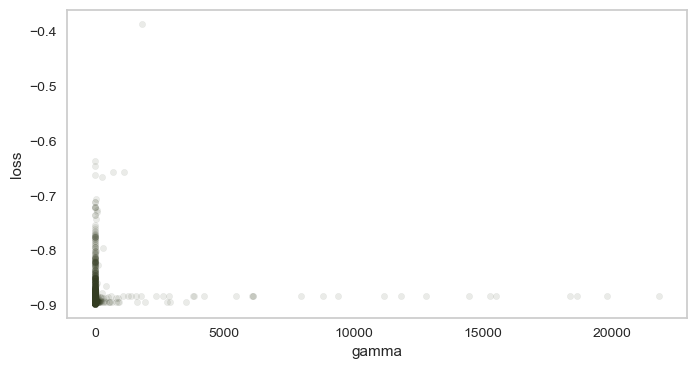

In [30]:
fig, ax = plt.subplots(figsize=(8,4))
(hyper2hr
 .plot
 .scatter(x='gamma',
          y='loss',
          alpha=.1,
          color=color_palette[8],
          ax=ax)
);

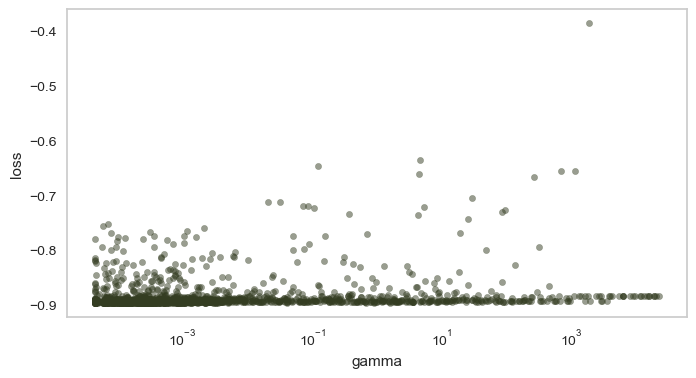

In [31]:
fig, ax = plt.subplots(figsize=(8,4))
(hyper2hr
 .plot
 .scatter(x='gamma',
          y='loss',
          alpha=.5,
          color=color_palette[8],
          ax=ax,
          logx=True,)
);

In [32]:
def plot_3d_mesh(df: pd.DataFrame, x_col: str, y_col: str, z_col: str) -> go.Figure:
    
    colorscale = [[i/(len(color_palette)-1), color] for i, color in enumerate(color_palette)]
    
    fig = go.Figure(data=[go.Mesh3d(x=df[x_col], y=df[y_col], z=df[z_col],
                                    intensity=df[z_col]/df[z_col].min(),
                                    colorscale=colorscale,
                                    hovertemplate=f"{z_col}: %{{z}}<br>{x_col}: %{{x}}<br>{y_col}: "
                                                                "%{{y}}<extra></extra>")],
                   )
    
    fig.update_layout(
        title=dict(text=f'{y_col} vs {x_col}'),
        scene=dict(
            xaxis_title=x_col,
            yaxis_title=y_col,
            zaxis_title=z_col),
        width=700,
        margin=dict(r=20, b=10, l=10, t=50)
    )
    return fig

def plot_3d_scatter(df: pd.DataFrame, x_col: str, y_col: str, z_col: str, color_col: str, color_palette, opacity: float=1) -> go.Figure:
    colorscale = [[i/(len(color_palette)-1), color] for i, color in enumerate(color_palette)]
    fig = px.scatter_3d(data_frame=df, x=x_col, y=y_col, z=z_col, color=color_col, color_continuous_scale=colorscale, opacity=opacity)
    return fig

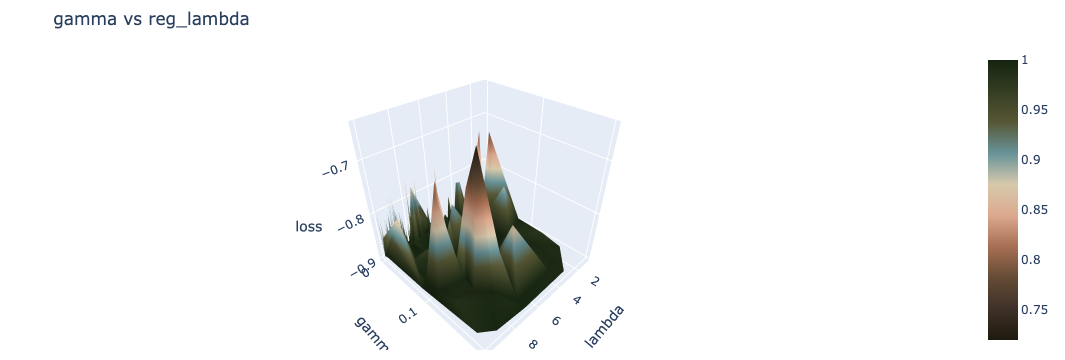

In [33]:
fig = plot_3d_mesh(hyper2hr.query('gamma < .2'),
                   'reg_lambda', 
                   'gamma', 
                   'loss')
fig

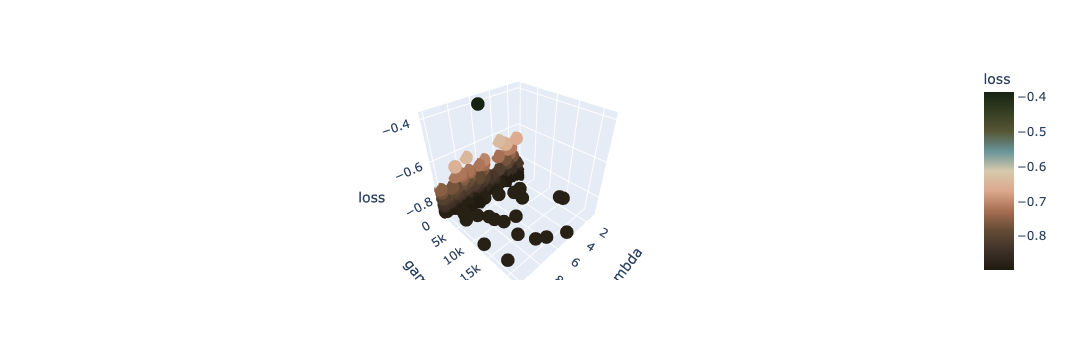

In [34]:
plot_3d_scatter(hyper2hr,
                'reg_lambda', 
                'gamma', 
                'loss',
                color_col='loss',
                color_palette=color_palette)

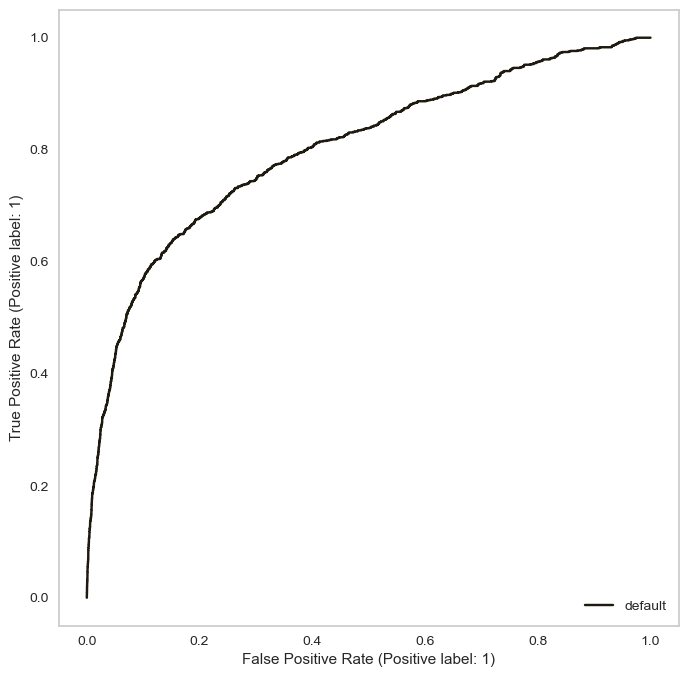

In [35]:
fig, ax = plt.subplots(figsize=(8,8))
metrics.RocCurveDisplay.from_estimator(loaded_model,
                                       loaded_pipeline.transform(X_test),
                                       y_test,
                                       ax=ax,
                                       label='default');

In [36]:
def get_tpr_fpr(probs, y_truth):
    """
    Given predicted probabilities and ground truth labels, 
    calculates TPR and FPR
    """
    tp = (probs == 1) & (y_truth == 1)
    tn = (probs < 1) & (y_truth == 0)
    fp = (probs == 1) & (y_truth == 0)
    fn = (probs < 1) & (y_truth == 1)
    tpr = tp.sum() / (tp.sum() + fn.sum())
    fpr = fp.sum() / (fp.sum() + tn.sum())
    return tpr, fpr

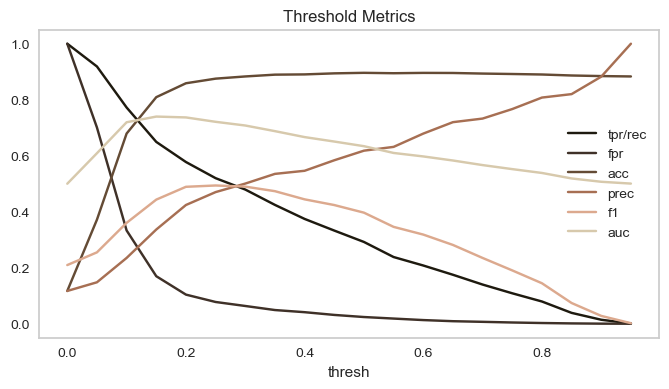

In [37]:
vals = []
for thresh in np.arange(0, 1, step=.05):
    probs = loaded_model.predict_proba(loaded_pipeline.transform(X_test))[:, 1]
    tpr, fpr = get_tpr_fpr(probs > thresh, y_test)
    val = [thresh, tpr, fpr]
    for metric in [metrics.accuracy_score, metrics.precision_score,
                   metrics.recall_score, metrics.f1_score,
                   metrics.roc_auc_score]:
        val.append(metric(y_test, probs > thresh))
    vals.append(val)
    
fig, ax = plt.subplots(figsize=(8, 4))
(pd.DataFrame(vals, columns=['thresh', 'tpr/rec', 'fpr', 'acc',
                             'prec', 'rec', 'f1', 'auc'])
   .drop(columns='rec')
   .set_index('thresh')
   .plot(ax=ax, title='Threshold Metrics')
);

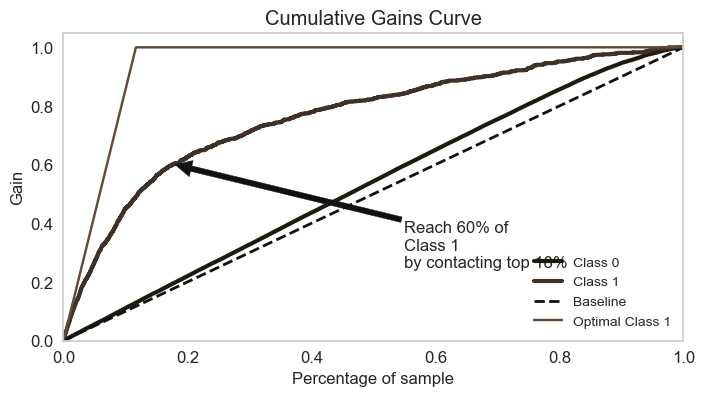

In [38]:
fig, ax = plt.subplots(figsize=(8, 4))
y_probs = loaded_model.predict_proba(loaded_pipeline.transform(X_test))
scikitplot.metrics.plot_cumulative_gain(y_test, y_probs, ax=ax)
ax.plot([0, (y_test == 1).mean(), 1], [0, 1, 1], label='Optimal Class 1')
ax.set_ylim(0, 1.05)
ax.annotate('Reach 60% of \nClass 1 \nby contacting top 18%', xy=(.18, .6),
            xytext=(.55, .25), arrowprops={'color': 'k'})
ax.legend();

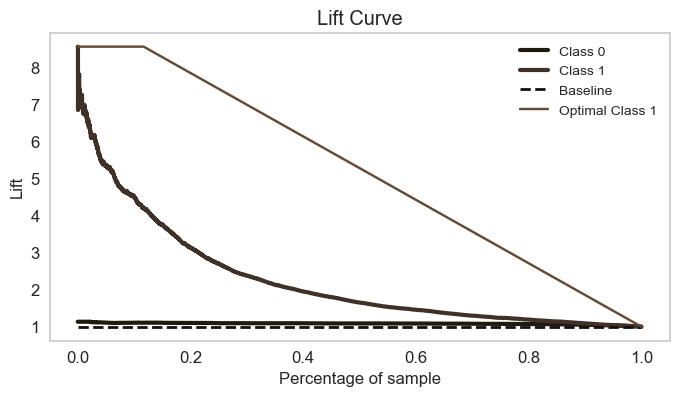

In [39]:
fig, ax = plt.subplots(figsize=(8, 4))
y_probs = loaded_model.predict_proba(loaded_pipeline.transform(X_test))
scikitplot.metrics.plot_lift_curve(y_test, y_probs, ax=ax)
mean = (y_test == 1).mean()
ax.plot([0, mean, 1], [1/mean, 1/mean, 1], label='Optimal Class 1')
ax.legend();

### Feature Importances

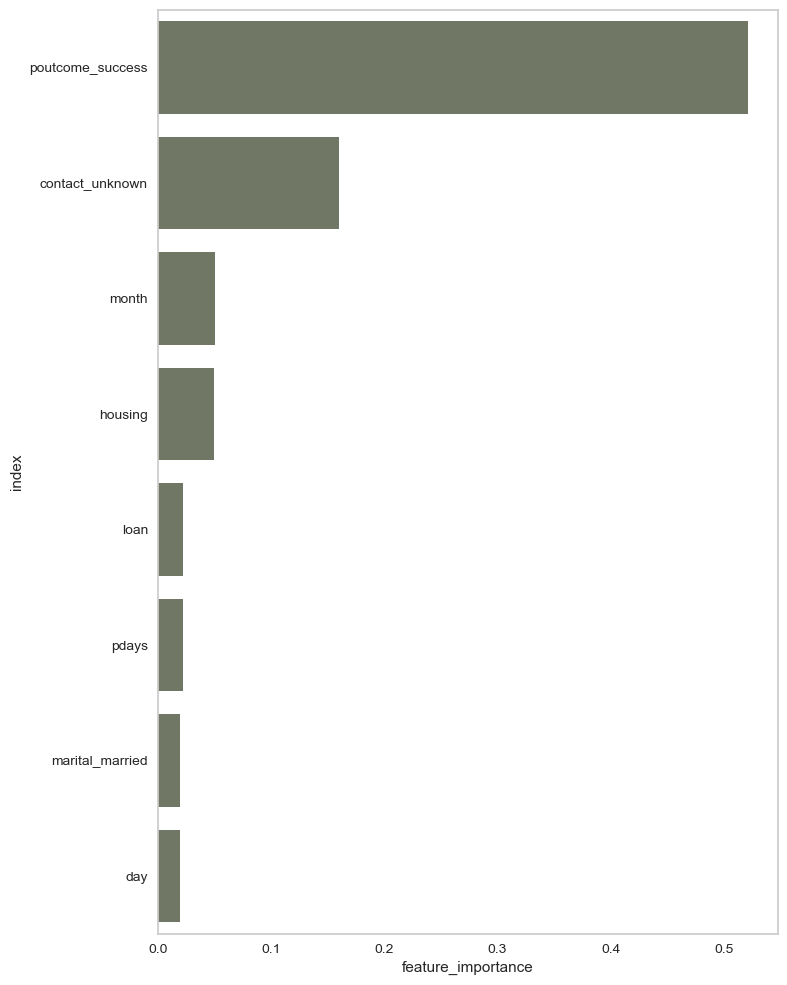

In [40]:
fig, ax = plt.subplots(figsize=(8, 12))
(so
 .Plot((pd
      .DataFrame(loaded_model.feature_importances_, index=selected_features)
      .rename(columns={0: "feature_importance"})
      .sort_values(by="feature_importance", ascending=False)
      .iloc[:8, :]
      .reset_index()),
     x='feature_importance',
     y='index'
    )
 .add(so.Bar(edgewidth=0))
 .theme({"axes.prop_cycle": matplotlib.cycler(color=[color_palette[8]])})
 .on(ax)
 .show())

**Insights:**

1. Gain measures the improvement in accuracy brought by a feature to the branches it is on (Average contribution of a feature to the model). Essentially, it is also the reduction in the training loss that results from adding a split on the feature.

2. A higher value of gain for a feature means it is more important for generating a prediction. It means changes in this feature's values have a more substantial effect on the output or prediction of the model. In this case, we have poutcome_success, contact_unknown, month, housing, and loan.

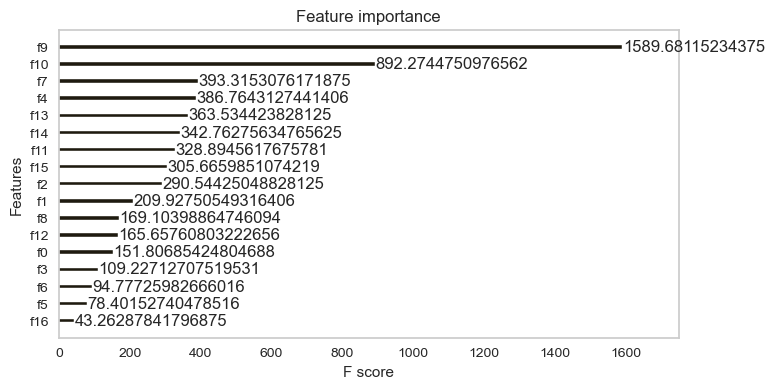

In [41]:
fig, ax = plt.subplots(figsize=(8, 4))
xgb.plot_importance(loaded_model, importance_type='cover', ax=ax);

### Surrogate Models

In [42]:
sur_reg_sk = tree.DecisionTreeRegressor(max_depth=4)
sur_reg_sk.fit(pd.DataFrame(loaded_pipeline.transform(X_train), columns=selected_features), 
               loaded_model.predict_proba(pd.DataFrame(loaded_pipeline.transform(X_train), columns=selected_features))[:,-1])

DecisionTreeRegressor(max_depth=4)

In [43]:
tree.export_graphviz(sur_reg_sk, 
                     out_file='img/sur-sk.dot',
                     feature_names=selected_features, 
                     filled=True, 
                     rotate=True,
                     fontname='Roboto Condensed')

**Insights:**
1. A surrogate model is a simple model to approximate the predictions of a more complex model. The main reason for using a surrogate model is to gain insight into the workings of the complex model, especially when the original model is a black-box (in this case, XGBoost). Here, we use DecisionTree due to its interpretability

2. Surrogate model can also provide insight into interactions. Nodes that split on a different feature than a parent node often have an interaction. It looks like contact_unknown and day might have some interactions

### xgbfir (Feature Interactions Reshaped)

In [44]:
xgbfir.saveXgbFI(loaded_model,
                 feature_names=selected_features,
                 OutputXlsxFile='xgbfir.xlsx')

In [45]:
xgbfir = pd.read_excel('xgbfir.xlsx')
pd.DataFrame(xgbfir
             .sort_values(by='Average Rank')
             .round(1)
            )

Interaction    Gain  FScore  wFScore  Average wFScore  Average Gain  \
1              month  7635.1    1099     95.9              0.1           6.9   
2            balance  6154.9    2873    272.0              0.1           2.1   
0   poutcome_success  9642.6     127     20.9              0.2          75.9   
6    contact_unknown  2896.7     137     42.6              0.3          21.1   
5              pdays  3810.3    1292     74.7              0.1           2.9   
3                age  5601.8    2237     65.6              0.0           2.5   
4                day  5168.7    1996     85.9              0.0           2.6   
8            housing  1511.8     222     14.6              0.1           6.8   
7           campaign  1889.8     913     51.0              0.1           2.1   
10   marital_married   509.6     186     18.7              0.1           2.7   
11              loan   483.1     167     13.6              0.1           2.9   
9           previous   723.4     450     11.8              0.0           1.6   
15  poutcome_unknown   194.9      92      9.4              0.1           2.1   
12   job_blue-collar   384.4     245      5.3              0.0           1.6   
14    marital_single   274.7     150      4.5              0.0           1.8   
13    job_unemployed   315.4     203      3.7              0.0           1.6   
16   pdays_contacted     1.9       1      0.0              0.0           1.9   

    Expected Gain  Gain Rank  FScore Rank  wFScore Rank  Avg wFScore Rank  \
1          2228.6          2            5             2                 6   
2           901.4          3            1             1                 5   
0          9416.3          1           15             8                 2   
6          2669.5          7           14             7                 1   
5           620.6          6            4             4                 9   
3          1410.8          4            2             5                13   
4           425.7          5            3             3                11   
8           626.1          9            9            10                 8   
7           338.5          8            6             6                10   
10          135.0         11           11             9                 4   
11          158.7         12           12            11                 7   
9            55.4         10            7            12                14   
15           15.3         16           16            13                 3   
12           31.7         13            8            14                15   
14           52.0         15           13            15                12   
13            9.8         14           10            16                16   
16            0.0         17           17            17                17   

    Avg Gain Rank  Expected Gain Rank  Average Rank  Average Tree Index  \
1               3                   3           3.5                42.8   
2              10                   5           4.2                46.0   
0               1                   1           4.7                48.4   
6               2                   2           5.5                44.3   
5               5                   7           5.8                43.1   
3               9                   4           6.2                46.0   
4               8                   8           6.3                44.5   
8               4                   6           7.7                45.7   
7              12                   9           8.5                44.6   
10              7                  11           8.8                40.9   
11              6                  10           9.7                45.0   
9              15                  12          11.7                44.5   
15             11                  15          12.3                45.2   
12             16                  14          13.3                46.9   
14             14                  13          13.7     

In [46]:
xgbfir_depth1 = pd.read_excel('xgbfir.xlsx', sheet_name='Interaction Depth 1')
pd.DataFrame(xgbfir_depth1
             .sort_values(by='Average Rank')
             .head(10)
             .round(1)
            )

Interaction    Gain  FScore  wFScore  \
3                        month|month  4745.2     213     30.1   
0                          day|month  7121.5     532     33.7   
7                    balance|balance  4239.3     954    182.3   
10             contact_unknown|month  3268.5      32      9.4   
5   contact_unknown|poutcome_success  4499.9      16     12.3   
16               age|contact_unknown  2401.7      47      6.7   
14                       month|pdays  2784.4     239     18.0   
2             month|poutcome_success  4952.9      23      4.7   
20                       pdays|pdays  2125.8     270     29.8   
8                          age|month  3611.4     382     11.2   

    Average wFScore  Average Gain  Expected Gain  Gain Rank  FScore Rank  \
3               0.1          22.3          840.6          4           18   
0               0.1          13.4          555.2          1            5   
7               0.2           4.4          799.4          8            1   
10              0.3         102.1         1871.3         11           60   
5               0.8         281.2         4148.3          6           85   
16              0.1          51.1         1830.9         17           46   
14              0.1          11.7          289.1         15           17   
2               0.2         215.3         4614.6          3           73   
20              0.1           7.9          250.8         21           16   
8               0.0           9.5          854.8          9           11   

    wFScore Rank  Avg wFScore Rank  Avg Gain Rank  Expected Gain Rank  \
3              3                16             15                   7   
0              2                39             21                  10   
7              1                10             71                   8   
10            17                 5              6                   4   
5             13                 1              2                   2   
16            24                15             10                   5   
14             7                35             23                  20   
2             31                 9              3                   1   
20             4                24             33                  23   
8             15                58             26                   6   

    Average Rank  Average Tree Index  Average Tree Depth  
3           10.5                37.5                 4.9  
0           13.0                41.6                 5.4  
7           16.5                53.3                 5.4  
10          17.2                29.8                 3.4  
5           18.2                23.8                 1.8  
16          19.5                37.1                 4.3  
14          19.5                41.6                 5.7  
2           20.0                46.0                 5.1  
20          20.2                43.8                 5.5  
8           20.8                45.0                 5.5

In [47]:
post_col_trans = pd.DataFrame(
                    (loaded_pipeline
                     .named_steps['col_trans']
                     .transform(
                         (loaded_pipeline
                          .named_steps['tweak_bank_marketing']
                          .transform(X_train)
                         )
                     )
                    ), columns=feature_names
                 )
post_col_trans.head()

age  campaign     pdays  previous   balance  job_blue-collar  \
0 -0.460434 -0.253797 -0.412126 -0.369755  0.391000              0.0   
1 -1.589641  0.602016  1.459368  5.874241  0.534763              0.0   
2  0.292371  0.602016 -0.412126 -0.369755  0.363833              0.0   
3  0.668773  3.597362 -0.412126 -0.369755  0.353089              0.0   
4 -0.272233  3.169455 -0.412126 -0.369755  0.364405              0.0   

   job_management  job_self-employed  job_services  job_technician  \
0             0.0                0.0           0.0             1.0   
1             0.0                0.0           0.0             0.0   
2             0.0                0.0           0.0             1.0   
3             0.0                0.0           0.0             0.0   
4             0.0                0.0           0.0             1.0   

   job_unemployed  marital_married  marital_single  contact_telephone  \
0             0.0              0.0             0.0                1.0   
1             1.0              0.0             1.0                0.0   
2             0.0              0.0             1.0                0.0   
3             1.0              1.0             0.0                1.0   
4             0.0              1.0             0.0                0.0   

   contact_unknown  poutcome_success  poutcome_unknown  education   day  \
0              0.0               0.0               1.0        1.0  28.0   
1              0.0               0.0               0.0        1.0   4.0   
2              0.0               0.0               1.0        1.0  11.0   
3              0.0               0.0               1.0        1.0  30.0   
4              0.0               0.0               1.0        1.0  25.0   

   month  default  housing  loan  balance_pos  pdays_contacted  \
0    1.0      0.0      0.0   0.0          1.0              0.0   
1    0.0      0.0      0.0   0.0          1.0              1.0   
2    1.0      0.0      1.0   0.0          1.0              0.0   
3    5.0      0.0      0.0   0.0          1.0              0.0   
4    1.0      0.0      0.0   0.0          1.0              0.0   

   previous_contacted  
0                 0.0  
1                 1.0  
2                 0.0  
3                 0.0  
4                 0.0

In [48]:
(post_col_trans
 .assign(deposit=y_train)
 .corr(method='spearman')
 .loc[:, ['month', 'day', 'balance', 'contact_telephone', 'contact_unknown', 'poutcome_success', 'poutcome_unknown', 'age', 'pdays']]
 .style
 .background_gradient(cmap=cm, vmin=-1, vmax=1)
 .format('{:.2f}')
)

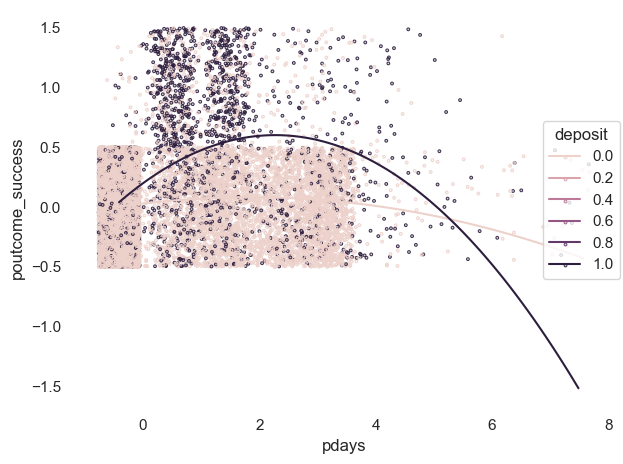

In [49]:
# fig = plt.figure(figsize=(8, 4))
(so
 .Plot(post_col_trans.assign(deposit=y_train), x='pdays', y='poutcome_success', color='deposit')
 .add(so.Dots(alpha=.9, pointsize=2), so.Jitter(x=.7, y=1))
 .add(so.Line(), so.PolyFit())
 # .scale(color='viridis')
 .theme({"axes.prop_cycle": matplotlib.cycler(color=[color_palette[8], color_palette[6]]), "axes.facecolor": "w", "grid.color": "#ffffff"})
 .show()
);

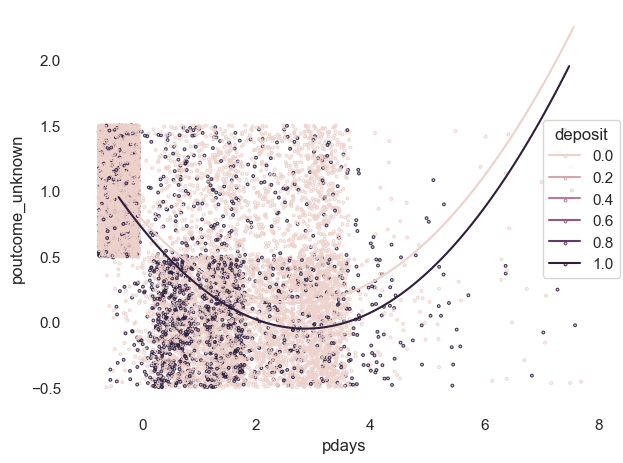

In [50]:
# fig = plt.figure(figsize=(8, 4))
(so
 .Plot(post_col_trans.assign(deposit=y_train), x='pdays', y='poutcome_unknown', color='deposit')
 .add(so.Dots(alpha=.9, pointsize=2), so.Jitter(x=.7, y=1))
 .add(so.Line(), so.PolyFit())
 # .scale(color='viridis')
 .theme({"axes.prop_cycle": matplotlib.cycler(color=[color_palette[8], color_palette[6]]), "axes.facecolor": "w", "grid.color": "#ffffff"})
 .show()
);

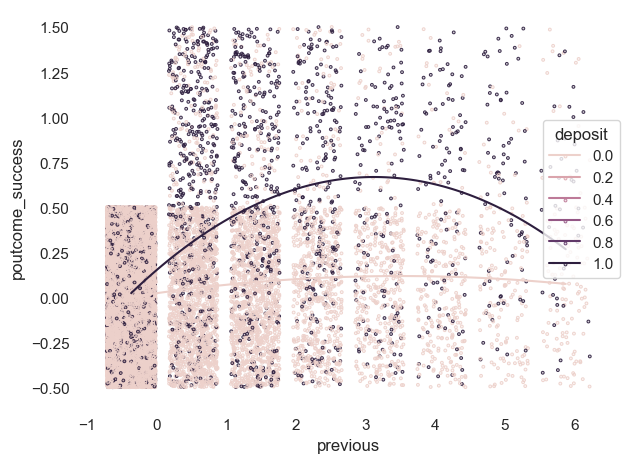

In [51]:
# fig = plt.figure(figsize=(8, 4))
(so
 .Plot(post_col_trans.assign(deposit=y_train), x='previous', y='poutcome_success', color='deposit')
 .add(so.Dots(alpha=.9, pointsize=2), so.Jitter(x=.7, y=1))
 .add(so.Line(), so.PolyFit())
 # .scale(color='viridis')
 .theme({"axes.prop_cycle": matplotlib.cycler(color=[color_palette[8], color_palette[6]]), "axes.facecolor": "w", "grid.color": "#ffffff"})
 .show()
);

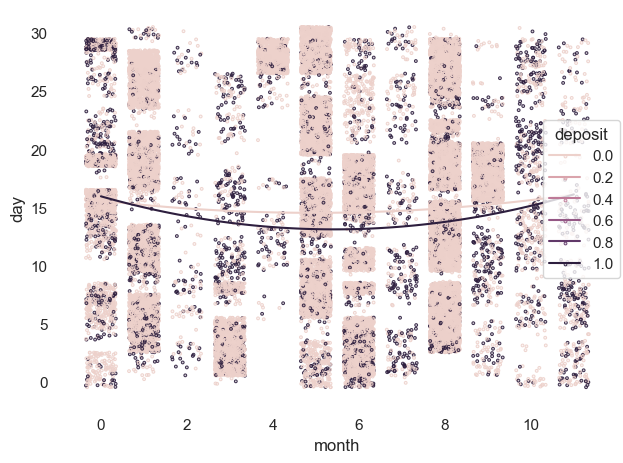

In [52]:
# fig = plt.figure(figsize=(8, 4))
(so
 .Plot(post_col_trans.assign(deposit=y_train), x='month', y='day', color='deposit')
 .add(so.Dots(alpha=.9, pointsize=2), so.Jitter(x=.7, y=1))
 .add(so.Line(), so.PolyFit())
 # .scale(color='viridis')
 .theme({"axes.prop_cycle": matplotlib.cycler(color=[color_palette[8], color_palette[6]]), "axes.facecolor": "w", "grid.color": "#ffffff"})
 .show()
);

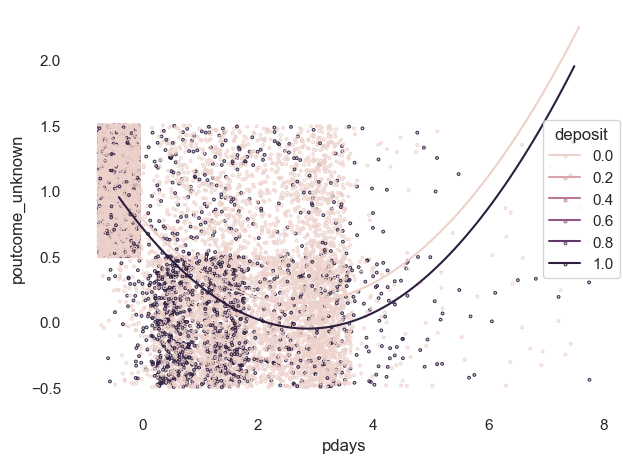

In [53]:
# fig = plt.figure(figsize=(8, 4))
(so
 .Plot(post_col_trans.assign(deposit=y_train), x='pdays', y='poutcome_unknown', color='deposit')
 .add(so.Dots(alpha=.9, pointsize=2), so.Jitter(x=.7, y=1))
 .add(so.Line(), so.PolyFit())
 # .scale(color='viridis')
 .theme({"axes.prop_cycle": matplotlib.cycler(color=[color_palette[8], color_palette[6]]), "axes.facecolor": "w", "grid.color": "#ffffff"})
 .show()
);

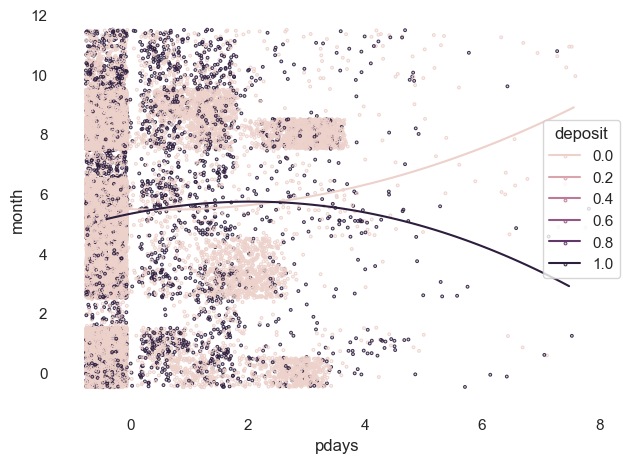

In [54]:
# fig = plt.figure(figsize=(8, 4))
(so
 .Plot(post_col_trans.assign(deposit=y_train), x='pdays', y='month', color='deposit')
 .add(so.Dots(alpha=.9, pointsize=2), so.Jitter(x=.7, y=1))
 .add(so.Line(), so.PolyFit())
 # .scale(color='viridis')
 .theme({"axes.prop_cycle": matplotlib.cycler(color=[color_palette[8], color_palette[6]]), "axes.facecolor": "w", "grid.color": "#ffffff"})
 .show()
);

### SHAP (no_client)

In [55]:
no_client

age         job  marital education default  balance housing loan  contact  \
0   58  management  married  tertiary      no     2143     yes   no  unknown   

   day month  duration  campaign  pdays  previous poutcome  
0    5   may       261         1     -1         0  unknown

In [56]:
shap_ex = shap.TreeExplainer(loaded_model)
vals = shap_ex(pd.DataFrame(no_client_transformed, columns=selected_features))

shap_df = pd.DataFrame(vals.values, columns=selected_features)
shap_df

age  campaign     pdays  previous   balance  job_blue-collar  \
0 -0.090622  0.088053  0.016486 -0.010237 -0.072065         -0.00447   

   job_unemployed  marital_married  marital_single  contact_unknown  \
0       -0.006212        -0.122899       -0.003898        -1.197899   

   poutcome_success  poutcome_unknown       day     month   housing      loan  \
0         -0.091155          0.014743 -0.013585 -0.185396 -0.132816  0.001656   

   pdays_contacted  previous_contacted  
0        -0.000002                 0.0

In [57]:
print(pd.concat([shap_df.sum(axis='columns')
                        .rename('pred') + vals.base_values,
                pd.Series(0, name='true')], axis='columns')
                  .assign(prob=lambda adf: (np.exp(adf.pred) / (1+np.exp(adf.pred)))))

       pred  true      prob
0 -3.694469     0  0.024258


In [58]:
# Since this is below zero, the default is "no"
shap_ex.expected_value

-1.8841516

In [59]:
# < 0 therefore ... "no"
shap_ex.expected_value + vals.values[0].sum()

-3.6944692

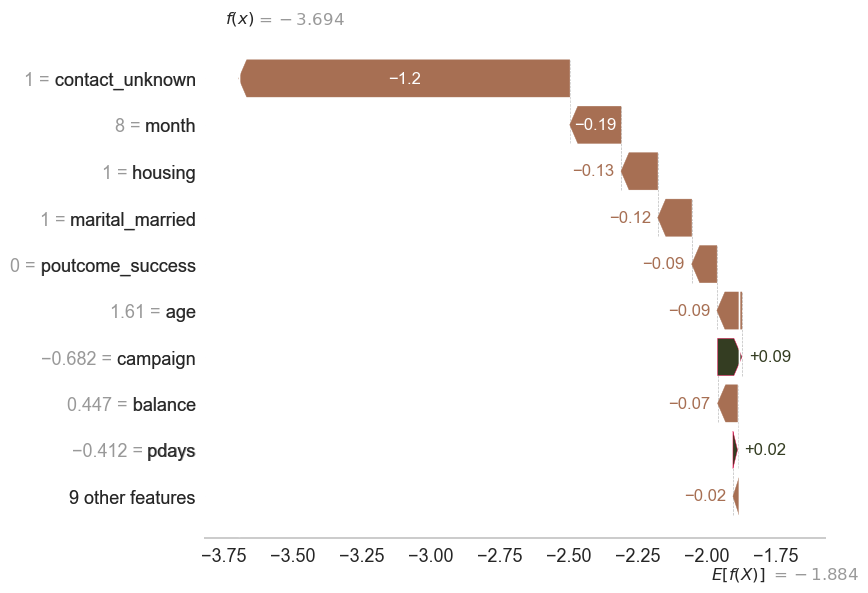

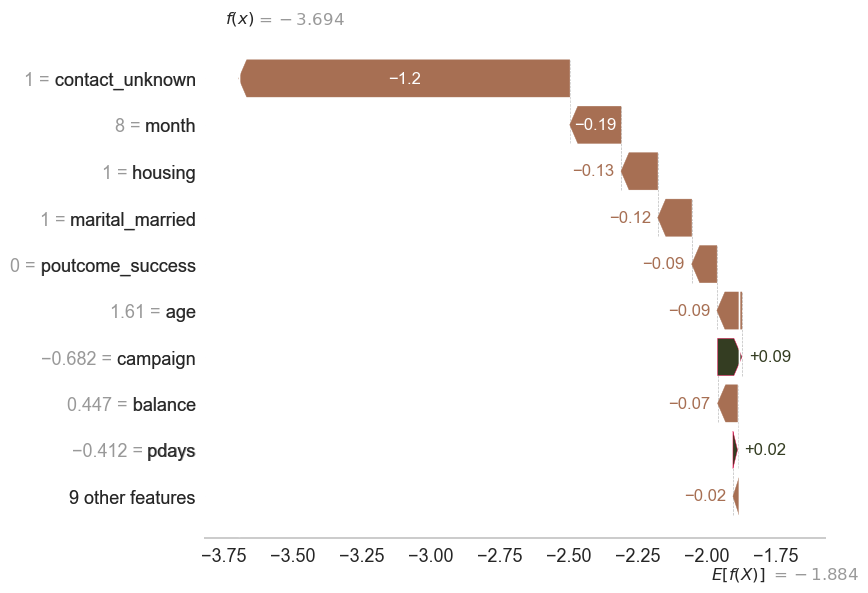

In [60]:
# Waterfall plot to explore SHAP values. 
# This plots an explanation of a single prediction.
# It displays how the SHAP value from each column impacts the result
# Default SHAP colors
default_pos_color = "#ff0051"
default_neg_color = "#008bfb"

# Custom colors
positive_color = color_palette[8]
negative_color = color_palette[3]
        
fig = plt.figure(figsize=(8,4))
fig = shap.plots.waterfall(vals[0], show=False)
        
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if (isinstance(fcc, matplotlib.patches.FancyArrow)):
            if (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_pos_color):
                fcc.set_facecolor(positive_color)
            elif (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_neg_color):
                fcc.set_color(negative_color)
        elif (isinstance(fcc, plt.Text)):
            if (matplotlib.colors.to_hex(fcc.get_color()) == default_pos_color):
                fcc.set_color(positive_color)
            elif (matplotlib.colors.to_hex(fcc.get_color()) == default_neg_color):
                fcc.set_color(negative_color)

fig

**Insights:**
1. Take E[f(X)]=-1.884 as the baseline
2. Add up -1.2, -0.19, etc. to obtain f(x)=-3.694
3. This value is less than 0, which explains the deposit outcome "No". 

### Force Plot (Flattened version of Waterfall plot) (no_client)

In [61]:
res = shap.plots.force(base_value=vals.base_values,
                       shap_values=vals.values[0,:],
                       features=selected_features,
                       matplotlib=True,
                       show=False,
                       plot_cmap=[positive_color, negative_color])
res.savefig('img/shap_forceplot_no_client.png', dpi=600, bbox_inches='tight')

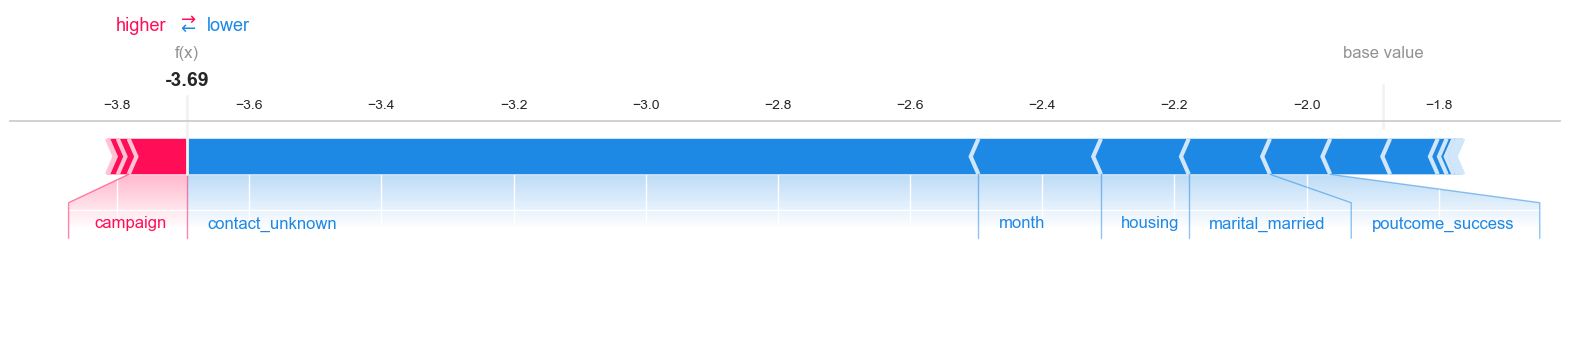

In [62]:
res

### SHAP (yes_client)

In [63]:
shap_ex = shap.TreeExplainer(loaded_model)
vals = shap_ex(pd.DataFrame(yes_client_transformed, columns=selected_features))

shap_df = pd.DataFrame(vals.values, columns=selected_features)
shap_df

age  campaign     pdays  previous   balance  job_blue-collar  \
0 -0.086507 -0.020607 -0.348443 -0.025725  0.105959         0.006395   

   job_unemployed  marital_married  marital_single  contact_unknown  \
0       -0.012138        -0.066007        0.012721         0.261436   

   poutcome_success  poutcome_unknown       day     month   housing      loan  \
0          1.916315          0.059688  0.146899 -0.074707  0.154849  0.037481   

   pdays_contacted  previous_contacted  
0          0.00012                 0.0

In [64]:
print(pd.concat([shap_df.sum(axis='columns')
                        .rename('pred') + vals.base_values,
                pd.Series(1, name='true')], axis='columns')
                  .assign(prob=lambda adf: (np.exp(adf.pred) / (1+np.exp(adf.pred)))))

       pred  true      prob
0  0.183577     1  0.545766


In [65]:
# Since this is below zero, the default is "no"
shap_ex.expected_value

-1.8841516

In [66]:
# > 0 therefore ... "yes"
shap_ex.expected_value + vals.values[0].sum()

0.18357694

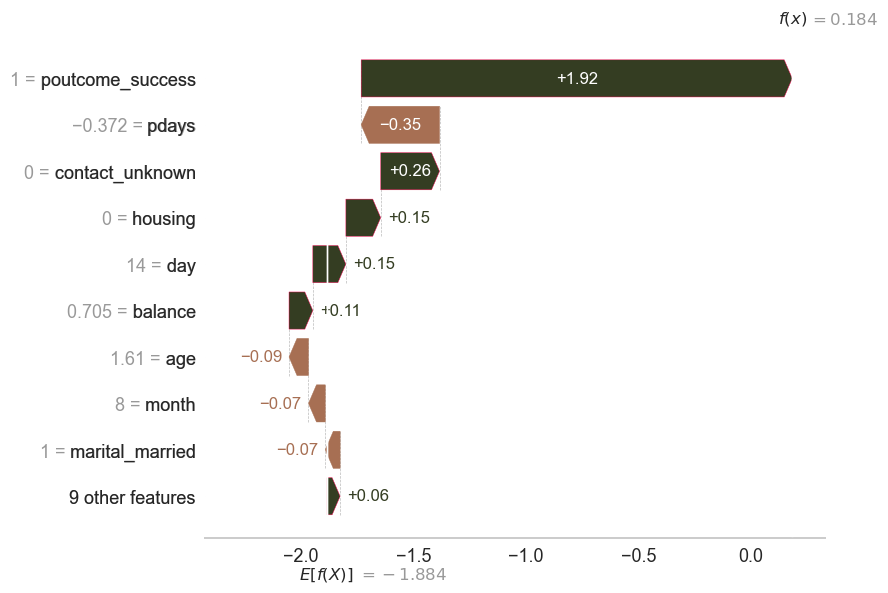

In [67]:
# Waterfall plot to explore SHAP values. 
# This plots an explanation of a single prediction.
# It displays how the SHAP value from each column impacts the result
fig = plt.figure(figsize=(8,4))
fig = shap.plots.waterfall(vals[0], show=False)
        
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if (isinstance(fcc, matplotlib.patches.FancyArrow)):
            if (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_pos_color):
                fcc.set_facecolor(positive_color)
            elif (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_neg_color):
                fcc.set_color(negative_color)
        elif (isinstance(fcc, plt.Text)):
            if (matplotlib.colors.to_hex(fcc.get_color()) == default_pos_color):
                fcc.set_color(positive_color)
            elif (matplotlib.colors.to_hex(fcc.get_color()) == default_neg_color):
                fcc.set_color(negative_color)

fig

### Force Plot (Flattened version of Waterfall plot) (yes_client)

In [68]:
res = shap.plots.force(base_value=vals.base_values,
                       shap_values=vals.values[0,:],
                       features=selected_features,
                       matplotlib=True,
                       show=False,
                       plot_cmap=[positive_color, negative_color],)
res.savefig('img/shap_forceplot_yes_client.png', dpi=600, bbox_inches='tight')

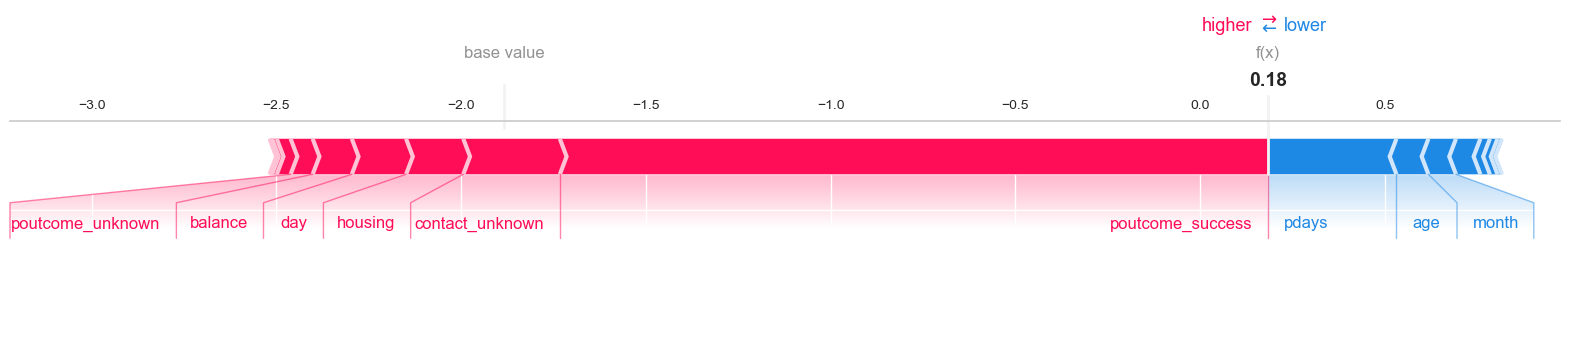

In [69]:
res

### Understanding Features with Dependence Plots

In [70]:
shap_ex = shap.TreeExplainer(loaded_model)
vals = shap_ex(pd.DataFrame(loaded_pipeline.transform(X_test), columns=selected_features))

shap_df = pd.DataFrame(vals.values, columns=selected_features)
shap_df

age  campaign     pdays  previous   balance  job_blue-collar  \
0    -0.093727 -0.005319  0.016674 -0.015388 -0.002428         0.018342   
1    -0.111073  0.005508  0.003368 -0.022524  0.011782        -0.003274   
2     0.262404 -0.252498  0.004536 -0.011691  0.045396        -0.008915   
3     0.121069 -0.074221  0.001752 -0.020345  0.101325         0.024496   
4    -0.071061  0.073471  0.021923 -0.023326  0.096061         0.004632   
...        ...       ...       ...       ...       ...              ...   
9038  0.344873 -0.103329 -0.021502 -0.009385 -0.494825         0.045643   
9039 -0.179948  0.041229 -0.008923 -0.035831  0.054800         0.003045   
9040  0.003774 -0.031235 -0.003945 -0.031629  0.062936         0.005898   
9041  0.422468 -0.098258  0.171010  0.121829 -0.125227        -0.002466   
9042  0.003231  0.139855 -0.132034 -0.033495 -0.154922        -0.009028   

      job_unemployed  marital_married  marital_single  contact_unknown  \
0          -0.004032        -0.154551       -0.014903        -0.794106   
1          -0.003534        -0.334317       -0.011279        -0.836234   
2           0.000751        -0.093403       -0.007737        -0.698275   
3          -0.000474        -0.137118       -0.002878        -0.784443   
4           0.006946         0.044344        0.054679         0.232975   
...              ...              ...             ...              ...   
9038       -0.004350         0.121293        0.032805        -0.590900   
9039       -0.003974        -0.122645       -0.029427         0.218404   
9040        0.001298        -0.142487       -0.020649         0.173454   
9041        0.033109        -0.010437        0.001174         0.193565   
9042       -0.006394        -0.062198       -0.024256        -0.029377   

      poutcome_success  poutcome_unknown       day     month   housing  \
0            -0.094316          0.003601 -0.070695 -0.184043 -0.087691   
1            -0.095964         -0.001198  0.176689 -0.119320 -0.100584   
2            -0.096213          0.003314 -0.013851  0.483715 -0.098298   
3            -0.094351          0.001892  0.151026 -0.154398 -0.079987   
4            -0.086005          0.013468 -0.216476  0.151248 -0.137949   
...                ...               ...       ...       ...       ...   
9038         -0.093850          0.000873 -0.164969  0.155247  0.039909   
9039         -0.108458          0.013937  0.054751 -0.090871 -0.185647   
9040         -0.113006         -0.009548  0.022198 -0.232715 -0.135974   
9041         -0.134357          0.053660 -0.001535 -0.106381  0.040592   
9042         -0.098686         -0.189446  0.271307  0.538848 -0.212464   

          loan  pdays_contacted  previous_contacted  
0    -0.025202        -0.000002                 0.0  
1     0.025952        -0.000003                 0.0  
2     0.003766        -0.000003                 0.0  
3     0.016677        -0.000003                 0.0  
4     0.037012        -0.000007                 0.0  
...        ...              ...                 ...  
9038 -0.266115        -0.000004                 0.0  
9039  0.032433        -0.000004                 0.0  
9040  0.042820        -0.000007                 0.0  
9041  0.010238         0.000238                 0.0  
9042 -0.347106         0.000196                 0.0  

[9043 rows x 18 columns]

/opt/miniconda3/envs/torch/lib/python3.9/site-packages/shap/plots/_beeswarm.py:375: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



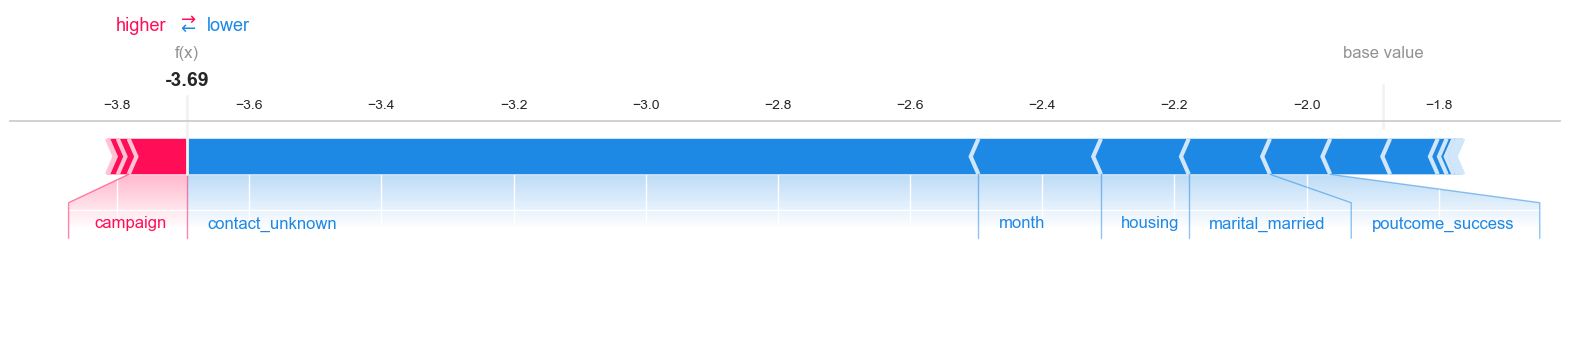

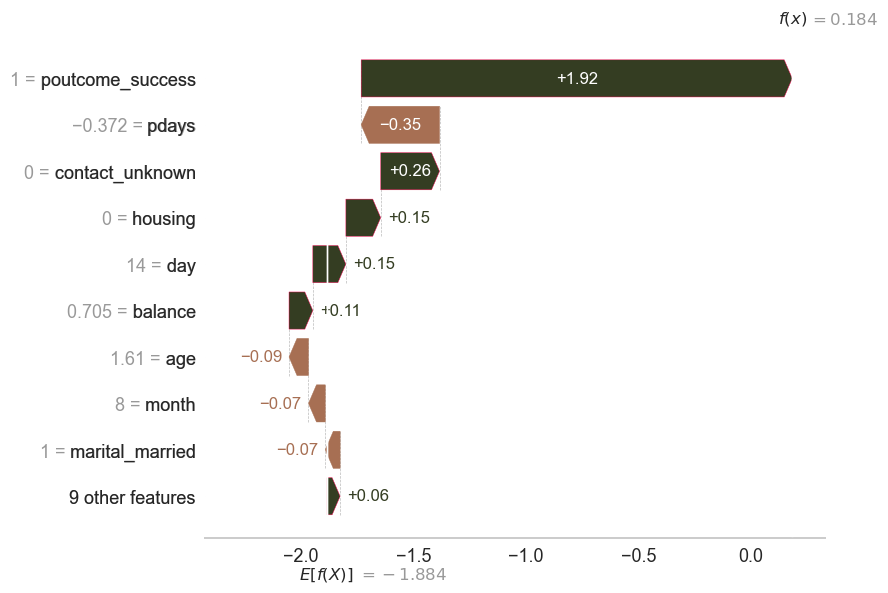

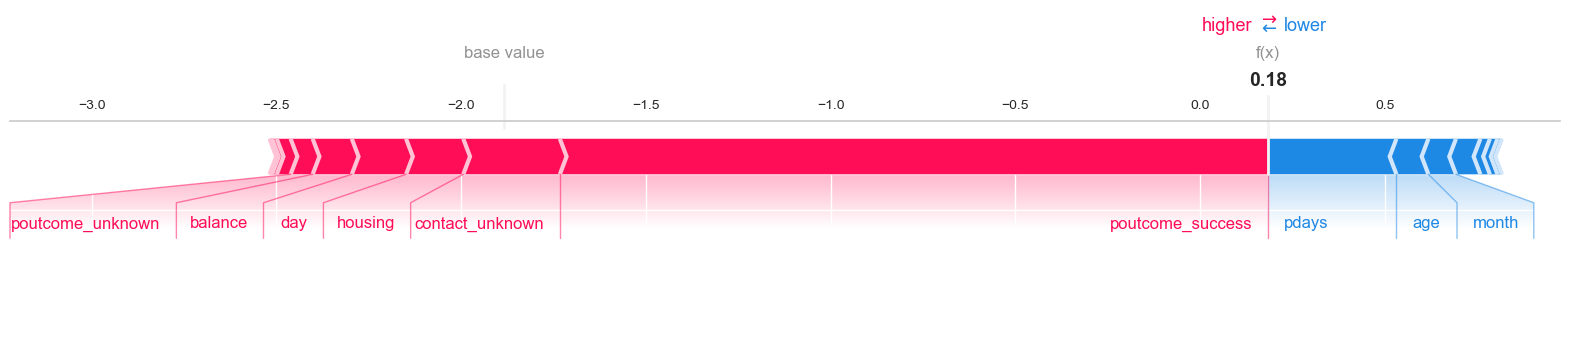

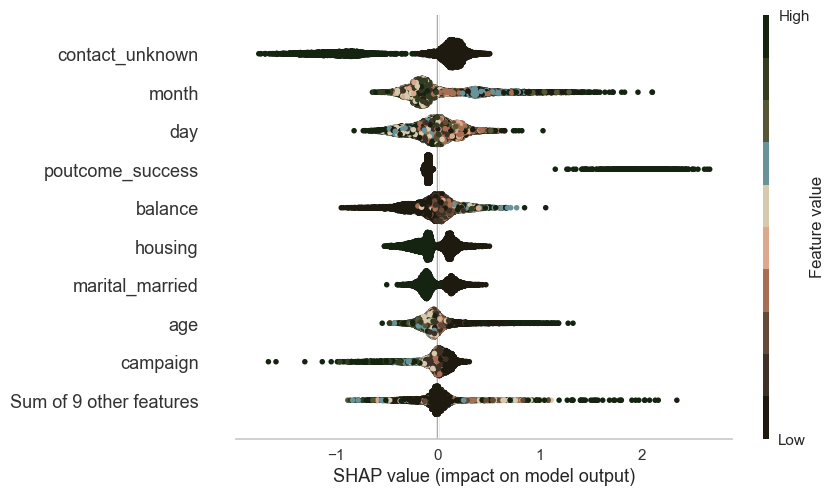

In [71]:
fig = plt.figure(figsize=(8, 4))
fig = shap.plots.beeswarm(vals, color=cm)
fig

### ICE, PDP

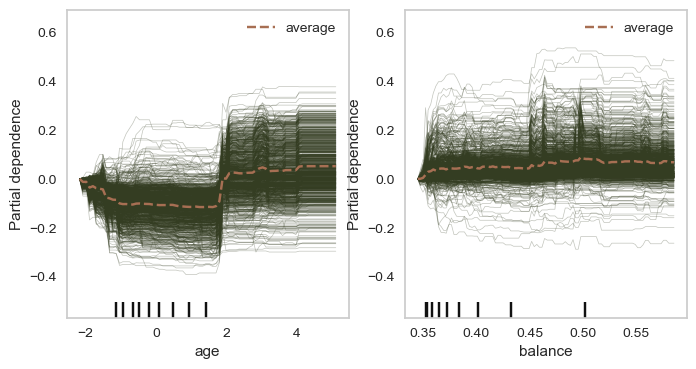

In [72]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
PartialDependenceDisplay.from_estimator(loaded_model, 
                                        pd.DataFrame(loaded_pipeline.transform(X_train), columns=selected_features),
                                        features=['age', 'balance'],
                                        centered=True,
                                        kind='both',
                                        ax=axes,
                                        ice_lines_kw={"color": color_palette[8]},
                                        pd_line_kw={"color": color_palette[3]})
plt.show();

In [73]:
selected_features

array(['age', 'campaign', 'pdays', 'previous', 'balance',
       'job_blue-collar', 'job_unemployed', 'marital_married',
       'marital_single', 'contact_unknown', 'poutcome_success',
       'poutcome_unknown', 'day', 'month', 'housing', 'loan',
       'pdays_contacted', 'previous_contacted'], dtype=object)

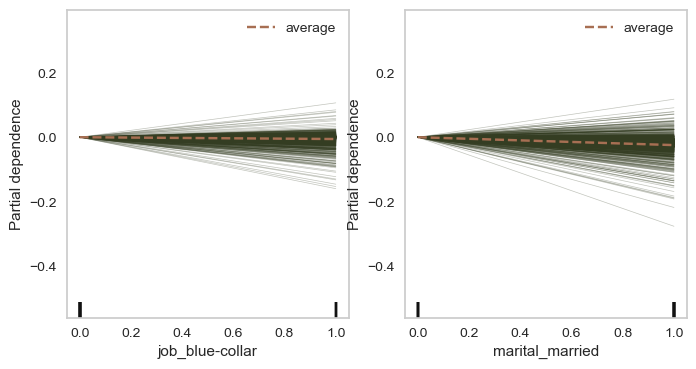

In [74]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
PartialDependenceDisplay.from_estimator(loaded_model, 
                                        pd.DataFrame(loaded_pipeline.transform(X_train), columns=selected_features),
                                        features=['job_blue-collar', 'marital_married'],
                                        centered=True,
                                        kind='both',
                                        ax=axes,
                                        ice_lines_kw={"color": color_palette[8]},
                                        pd_line_kw={"color": color_palette[3]})
plt.show();

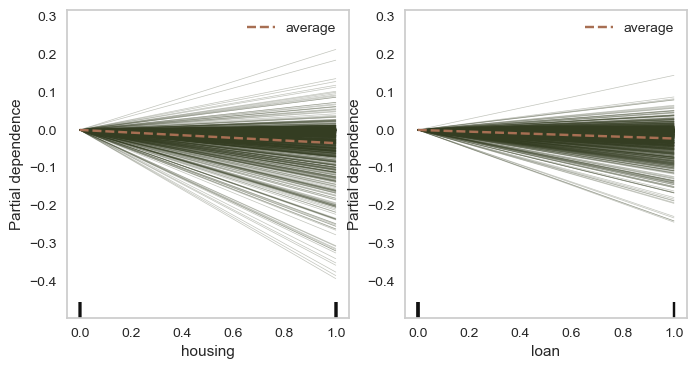

In [75]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
PartialDependenceDisplay.from_estimator(loaded_model, 
                                        pd.DataFrame(loaded_pipeline.transform(X_train), columns=selected_features),
                                        features=['housing', 'loan'],
                                        centered=True,
                                        kind='both',
                                        ax=axes,
                                        ice_lines_kw={"color": color_palette[8]},
                                        pd_line_kw={"color": color_palette[3]})
plt.show();

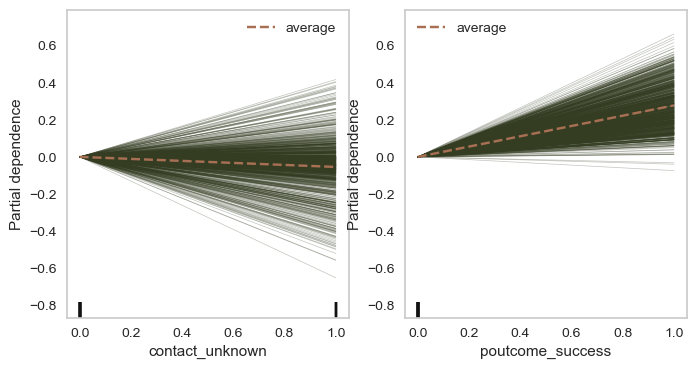

In [76]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
PartialDependenceDisplay.from_estimator(loaded_model, 
                                        pd.DataFrame(loaded_pipeline.transform(X_train), columns=selected_features),
                                        features=['contact_unknown', 'poutcome_success'],
                                        centered=True,
                                        kind='both',
                                        ax=axes,
                                        ice_lines_kw={"color": color_palette[8]},
                                        pd_line_kw={"color": color_palette[3]})
plt.show();